In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl import config
from stable_baselines3.common.logger import configure
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3 import A2C, PPO, DDPG, SAC, TD3
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

%matplotlib inline


In [2]:
'''
stock_lst={'현대건설':'000720','KB금융':'105560','현대로템':'064350',
           '강원랜드':'035250','현대모비스':'012330','포스코인터내셔널':'047050',
           '현대차':'005380','한국가스공사':'036460','LG전자':'066570','SK하이닉스':'000660',
           'POSCO홀딩스':'005490','KT':'030200','LG화학':'051910', # Stock
           'KODEX인버스':'114800','KODEX200선물인버스2x':'252670'} # ETF
'''

df=pd.read_csv('./RL_project_STAR/original_df_v2.csv',index_col=0)

technical_index=['boll_low','boll_mid','boll_high','macd','macd_sig','macd_osc','rsi','rsi_sig','fast_k','slow_k','slow_d']

fe = FeatureEngineer(
                    use_technical_indicator=False,
                    #tech_indicator_list = technical_index,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)
processed

Successfully added turbulence index


,date,tic,open,high,low,close,volume,day,boll_low,boll_mid,boll_high,macd,macd_sig,macd_osc,rsi,rsi_sig,fast_k,slow_k,slow_d,turbulence
0,2016-11-04,660,41150,41400,40850,41200,2600930,1,39686.704823,41362.50,43038.295177,229.674599,328.373093,-98.698494,53.0,57.000000,49.473684,47.719298,51.111111,0.000000
1,2016-11-04,720,40476,40476,39405,39795,335401,1,38898.584395,40869.75,42840.915605,264.619248,578.287012,-313.667764,45.0,46.888889,25.789362,25.097125,21.721539,0.000000
2,2016-11-04,5380,136500,137000,135500,136000,345493,1,130249.020424,135975.00,141700.979576,-25.989197,-406.923421,380.934225,40.0,44.666667,45.000000,58.333333,74.444444,0.000000
3,2016-11-04,5490,238000,238000,234500,238000,168319,1,225828.627267,237725.00,249621.372733,1956.750670,2788.289373,-831.538703,46.0,47.222222,35.897436,34.719435,37.032082,0.000000
4,2016-11-04,12330,267000,268000,264000,265000,116780,1,254734.810681,266425.00,278115.189319,-3123.674594,-4258.974498,1135.299904,37.0,34.666667,46.666667,55.555556,61.665620,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22315,2022-11-22,64350,29000,29200,28450,28850,4387215,1488,22275.010214,25560.00,28844.989786,787.038600,267.936900,519.101699,67.0,59.777778,86.486486,80.329025,78.817429,19.302335
22316,2022-11-22,66570,90300,90700,89100,89500,392751,1488,76599.562933,88565.00,100530.437067,2259.793263,2293.833276,-34.040013,53.0,63.333333,47.752809,54.087002,62.529754,19.302335
22317,2022-11-22,105560,49800,50100,49400,49800,887540,1488,45877.840643,48357.50,50837.159357,726.006333,604.636115,121.370217,60.0,59.777778,91.891892,83.783784,77.477477,19.302335
22318,2022-11-22,114800,4870,4900,4845,4900,22427910,1488,4627.685988,4939.75,5251.814012,-93.073486,-93.460347,0.386860,100.0,100.000000,43.956044,34.517964,26.688756,19.302335


In [5]:

train_df = processed
stock_dimension = len(train_df.tic.unique()) #종목 수
state_space = 1 + 2*stock_dimension + len(technical_index)*stock_dimension #???
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

train_start = '2016-09-23' #train set start date
train_end = '2021-12-31' #train set end date
val_test_start = '2022-01-01' #test set start date
val_test_end = '2022-11-22' #test set end date

train = data_split(train_df, start = train_start, end = train_end)
valid = data_split(train_df, start = val_test_start, end = val_test_end)

env_kwargs = {
    "hmax": 100, #한번에 거래 가능한 최대 주식 수
    "initial_amount": int(10000000), #처음 잔고 새로 지정
    "num_stock_shares": [0] * stock_dimension,
    "buy_cost_pct": [0.0023] * stock_dimension, #매수 거래비용 우리나라 맞게
    "sell_cost_pct": [0.0023] * stock_dimension, #매도 거래비용 우리나라 맞게
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": technical_index, #기술지표 목록
    "action_space": stock_dimension,
    "reward_scaling": 1e-4, #discount factor
    "print_verbosity":5 
    }

e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

agent = DRLAgent(env = env_train)

Stock Dimension: 15, State Space: 196
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [6]:
test_stock_dimension = len(train_df.tic.unique()) #종목 수
test_state_space = 1 + 2*test_stock_dimension + len(technical_index)*test_stock_dimension
print(f"Stock Dimension: {test_stock_dimension}, State Space: {test_state_space}")

test_env_kwargs = {
    "hmax": 100, #한번에 거래 가능한 최대 주식 수
    "initial_amount": int(10000000), #처음 잔고 새로 지정
    "num_stock_shares": [0] * test_stock_dimension,
    "buy_cost_pct": [0.0023] * test_stock_dimension, #매수 거래비용 우리나라 맞게
    "sell_cost_pct": [0.0023] * test_stock_dimension, #매도 거래비용 우리나라 맞게
    "state_space": test_state_space, 
    "stock_dim": test_stock_dimension, 
    "tech_indicator_list": technical_index, #기술지표 목록
    "action_space": test_stock_dimension,
    "reward_scaling": 1e-4, #discount factor
    "print_verbosity":5 
    }

e_test_gym = StockTradingEnv(df = valid, **test_env_kwargs)
env_test, _ = e_test_gym.get_sb_env()
print(type(env_test))

Stock Dimension: 15, State Space: 196
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [8]:
model_a2c = agent.get_model("a2c")

# set up logger
tmp_path = config.RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)

trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=1000) #3.8 s

trained_a2c.save('trained_a2c')

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c
-------------------------------------
| time/                 |           |
|    fps                | 94        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -21.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -1.13e+03 |
|    reward             | 4.263011  |
|    std                | 1         |
|    value_loss         | 2.59e+03  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 99        |
|    iterations         | 200       |
|    time_elapsed       | 10        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -

hit end!


<AxesSubplot:>

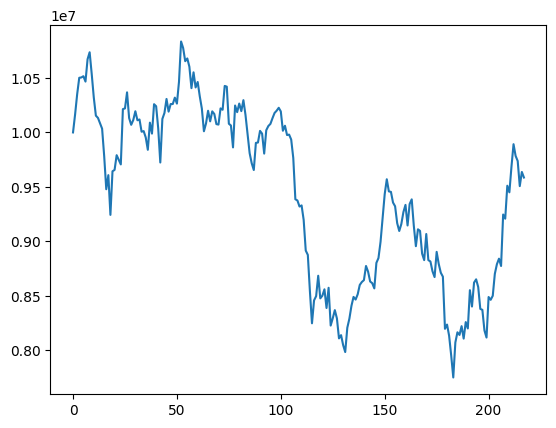

In [11]:
test_agent = DRLAgent(env= env_test)

load_model = A2C.load('./trained_a2c.zip')

account_memory, actions_menory = test_agent.DRL_prediction(load_model, e_test_gym, deterministic=True)

account_memory['account_value'].plot()

In [12]:
model_ppo = agent.get_model("ppo")

# set up logger
tmp_path = config.RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=1000) # 7.1s

trained_ppo.save('trained_ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Logging to results/ppo
----------------------------------
| time/              |           |
|    fps             | 152       |
|    iterations      | 1         |
|    time_elapsed    | 13        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.8905467 |
----------------------------------


hit end!


<AxesSubplot:>

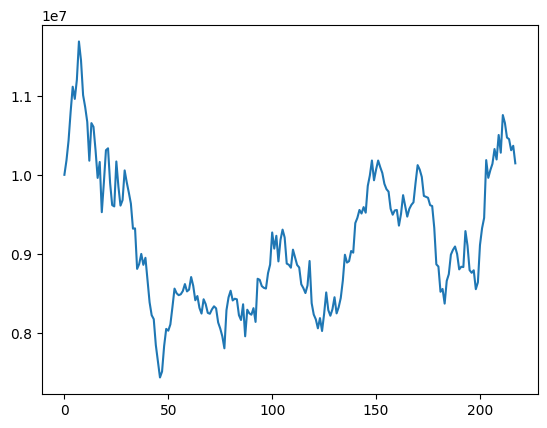

In [13]:
test_agent = DRLAgent(env = env_test)

load_model = PPO.load('./trained_ppo.zip')

account_memory_ppo, actions_menory = test_agent.DRL_prediction(load_model, e_test_gym, deterministic=True)

account_memory_ppo['account_value'].plot()

In [14]:
model_ddpg = agent.get_model("ddpg")

# set up logger
tmp_path = config.RESULTS_DIR + '/ddpg'
new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ddpg.set_logger(new_logger_ddpg)

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=1000) # 9.1s

trained_ddpg.save('trained_ddpg')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg
day: 1268, episode: 5
begin_total_asset: 10000000.00
end_total_asset: 16267425.15
total_reward: 6267425.15
total_cost: 1513569.85
total_trades: 4986
Sharpe: 0.444


hit end!


<AxesSubplot:>

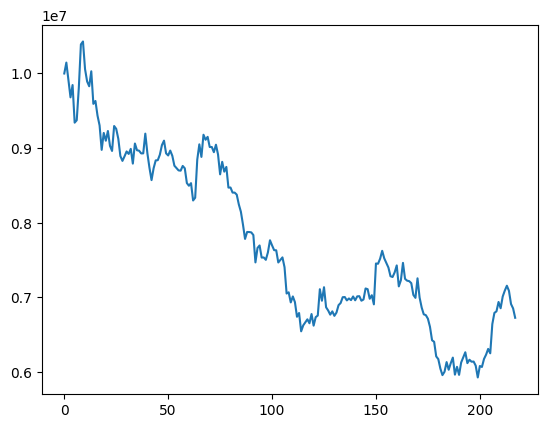

In [15]:
test_agent = DRLAgent(env = env_test)

load_model = DDPG.load('./trained_ddpg.zip')

account_memory_ddpg, actions_menory = test_agent.DRL_prediction(load_model, e_test_gym, deterministic=True)

account_memory_ddpg['account_value'].plot()

In [16]:
model_sac = agent.get_model("sac")

# set up logger
tmp_path = config.RESULTS_DIR + '/sac'
new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_sac.set_logger(new_logger_sac)

trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=1000) # 12.4s

trained_sac.save('trained_sac')

{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to results/sac


day: 217, episode: 15
begin_total_asset: 10000000.00
end_total_asset: 9047637.16
total_reward: -952362.84
total_cost: 55457.84
total_trades: 1739
Sharpe: -0.387
hit end!


<AxesSubplot:>

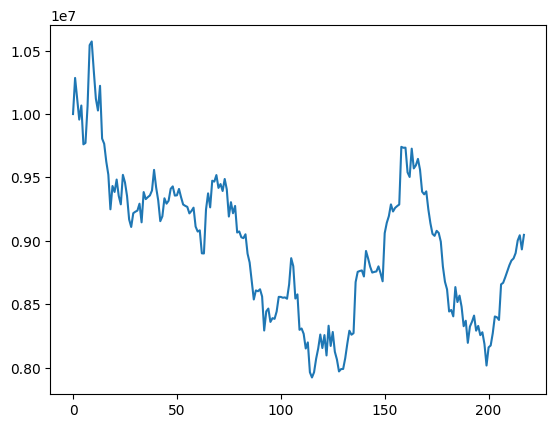

In [17]:
test_agent = DRLAgent(env = env_test)

load_model = SAC.load('./trained_sac.zip')

account_memory_sac, actions_menory = test_agent.DRL_prediction(load_model, e_test_gym, deterministic=True)

account_memory_sac['account_value'].plot()

In [18]:
model_td3 = agent.get_model("td3")

# set up logger
tmp_path = config.RESULTS_DIR + '/td3'
new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_td3.set_logger(new_logger_td3)

trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=1000) # 9.2s

trained_td3.save('trained_td3')

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device
Logging to results/td3


hit end!


<AxesSubplot:>

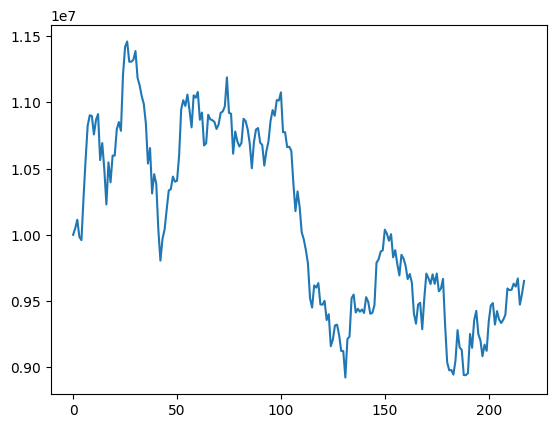

In [19]:
test_agent = DRLAgent(env = env_test)

load_model = TD3.load('./trained_td3.zip')

account_memory_td3, actions_menory = test_agent.DRL_prediction(load_model, e_test_gym, deterministic=True)

account_memory_td3['account_value'].plot()

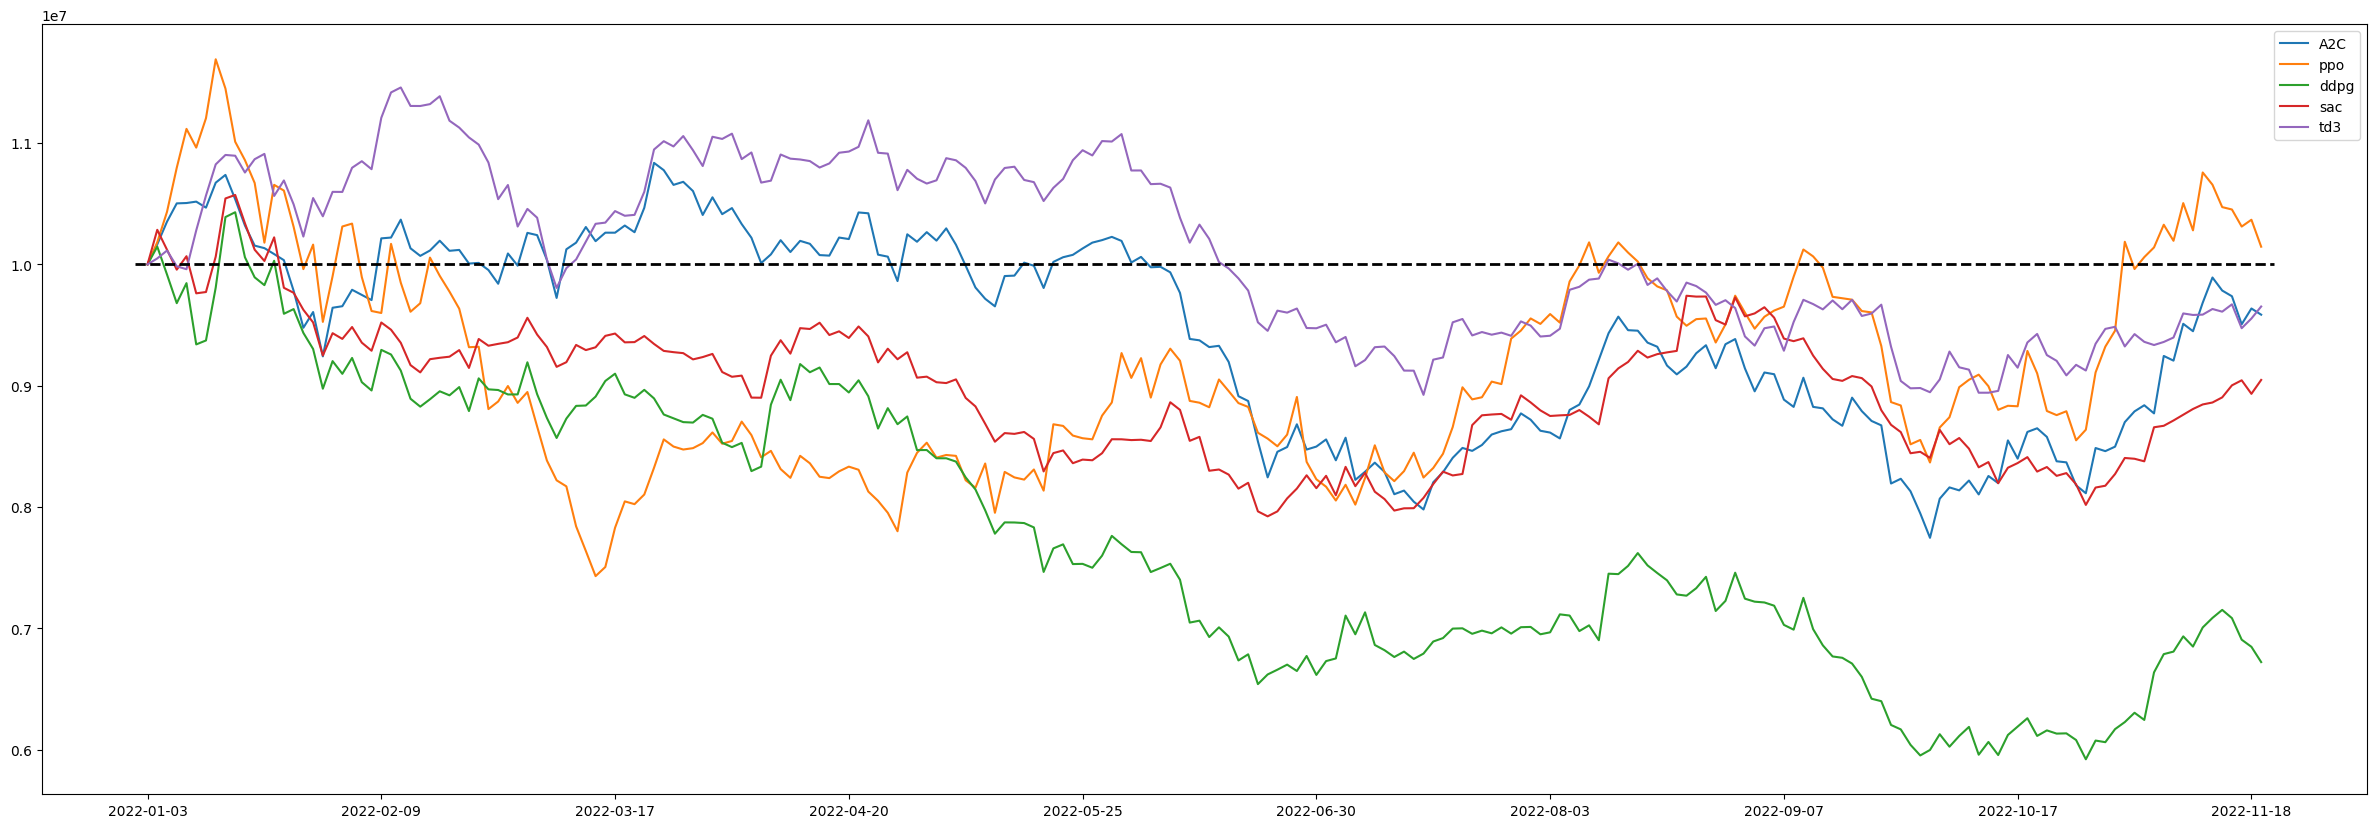

In [20]:
plt.figure(figsize=(30,10))

plt.plot(account_memory.date, account_memory.account_value, label='A2C')
plt.plot(account_memory_ppo.account_value, label='ppo')
plt.plot(account_memory_ddpg.account_value, label='ddpg')
plt.plot(account_memory_sac.account_value, label='sac')
plt.plot(account_memory_td3.account_value, label='td3')

x_ticks = [account_memory.iloc[i]['date'] for i in range(0,len(account_memory['date']),24)]
plt.xticks(x_ticks)
plt.axhline(1e+7, 0.04, 0.96, color='black', linestyle='--', linewidth=2)
plt.legend()
plt.show()